#**Import libraries**

In [5]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

#**1. Load Data**

In [7]:

df = pd.read_csv('phishing_site_urls.csv')

print("Dataset shape:", df.shape)

Dataset shape: (549346, 2)


**Check Class Distribution**

Label
good    392924
bad     156422
Name: count, dtype: int64


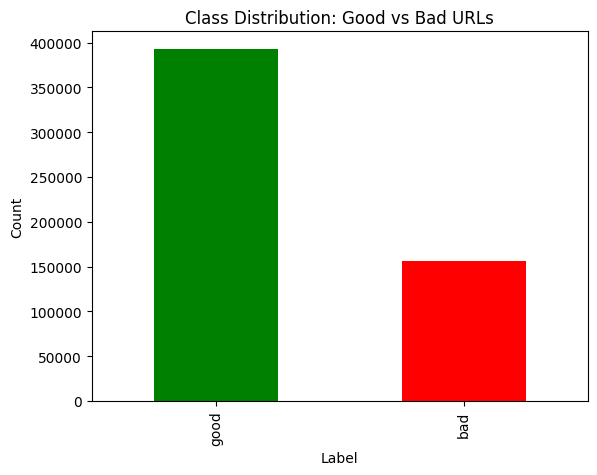

In [8]:
print(df['Label'].value_counts())
df['Label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Class Distribution: Good vs Bad URLs')
plt.ylabel('Count')
plt.show()

**Basic Sanity Check**

In [9]:
print("Nulls:\n", df.isnull().sum())
df = df.dropna().reset_index(drop=True)
df.columns = ['URL', 'Label']
# converting label data into binary
df['Label'] = df['Label'].map({'good': 0, 'bad': 1})

Nulls:
 URL      0
Label    0
dtype: int64


#**2. Feature Engineering**

In [10]:

def extract_features(url):
    features = {}
    parsed = urlparse(url)

    # Basic string features
    features['length'] = len(url)
    features['dots'] = url.count('.')
    features['hyphens'] = url.count('-')
    features['underscores'] = url.count('_')
    features['slashes'] = url.count('/')
    features['at_sign'] = url.count('@')
    features['question_mark'] = url.count('?')
    features['equal_sign'] = url.count('=')
    features['percent'] = url.count('%')
    features['digits'] = sum(c.isdigit() for c in url)
    features['letters'] = sum(c.isalpha() for c in url)

    # Domain-based
    features['domain_length'] = len(parsed.netloc)
    features['subdomains'] = parsed.netloc.count('.') - 1 if parsed.netloc else 0

    # Suspicious patterns (binary flags)
    features['has_ip'] = 1 if re.search(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', parsed.netloc) else 0
    features['has_suspicious_tld'] = 1 if parsed.netloc.endswith(('.tk', '.ml', '.ga', '.cf', '.gq')) else 0  # common phishing TLDs
    features['has_https'] = 1 if parsed.scheme == 'https' else 0
    features['has_http'] = 1 if parsed.scheme == 'http' else 0
    features['url_contains_login'] = 1 if 'login' in url.lower() else 0
    features['url_contains_secure'] = 1 if 'secure' in url.lower() else 0
    features['url_contains_account'] = 1 if 'account' in url.lower() else 0
    features['url_contains_verify'] = 1 if 'verify' in url.lower() else 0
    features['url_contains_update'] = 1 if 'update' in url.lower() else 0

    return pd.Series(features)

**Applying Feature Extraction**

In [11]:
print("⏳ Extracting features...")
X_features = df['URL'].apply(extract_features)
y = df['Label']

print("Feature shape:", X_features.shape)
X_features.head()

⏳ Extracting features...
Feature shape: (549346, 22)


,length,dots,hyphens,underscores,slashes,at_sign,question_mark,equal_sign,percent,digits,...,subdomains,has_ip,has_suspicious_tld,has_https,has_http,url_contains_login,url_contains_secure,url_contains_account,url_contains_verify,url_contains_update
0,225,6,4,4,10,0,1,4,0,58,...,0,0,0,0,0,1,0,0,0,0
1,81,5,2,1,4,0,0,2,0,1,...,0,0,0,0,0,0,0,0,0,0
2,177,7,1,0,11,0,0,0,0,47,...,0,0,0,0,0,0,1,0,0,1
3,60,6,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,116,1,1,0,10,0,1,0,0,21,...,0,0,0,0,0,0,0,0,0,0


#**3. Train-Test Split**

In [12]:

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 439476, Test size: 109870


#**4. Model Training**

In [13]:
# Option 1: Logistic Regression (fast + interpretable)
print("Training Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Option 2: Random Forest (more robust)
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

Training Logistic Regression...
Training Random Forest...


RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

#**5. Evaluation**

In [14]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=['Good', 'Bad']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Good', 'Bad'],
                yticklabels=['Good', 'Bad'])
    plt.title(f'{name} - Confusion Matrix')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()


Logistic Regression Accuracy: 0.7996
              precision    recall  f1-score   support

        Good       0.79      0.98      0.87     78585
         Bad       0.87      0.35      0.50     31285

    accuracy                           0.80    109870
   macro avg       0.83      0.66      0.69    109870
weighted avg       0.81      0.80      0.77    109870



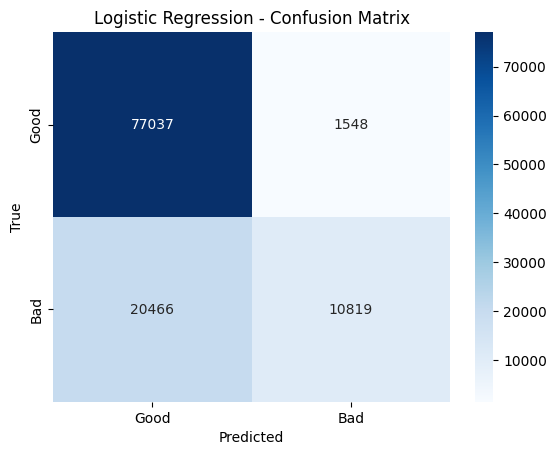


Random Forest Accuracy: 0.8158
              precision    recall  f1-score   support

        Good       0.80      0.99      0.88     78585
         Bad       0.94      0.38      0.54     31285

    accuracy                           0.82    109870
   macro avg       0.87      0.68      0.71    109870
weighted avg       0.84      0.82      0.79    109870



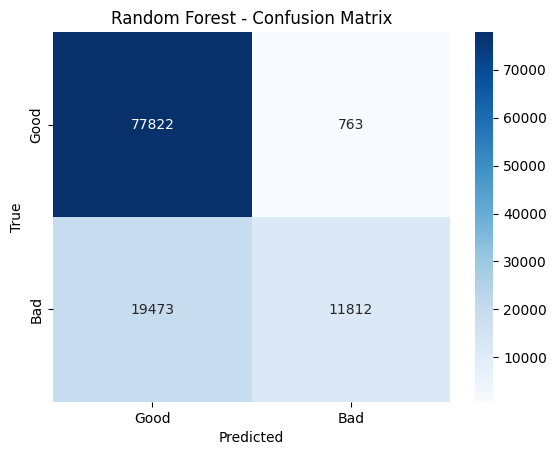

In [15]:
evaluate_model(lr, X_test, y_test, "Logistic Regression")
evaluate_model(rf, X_test, y_test, "Random Forest")

**Feature Importance (Random Forest)**

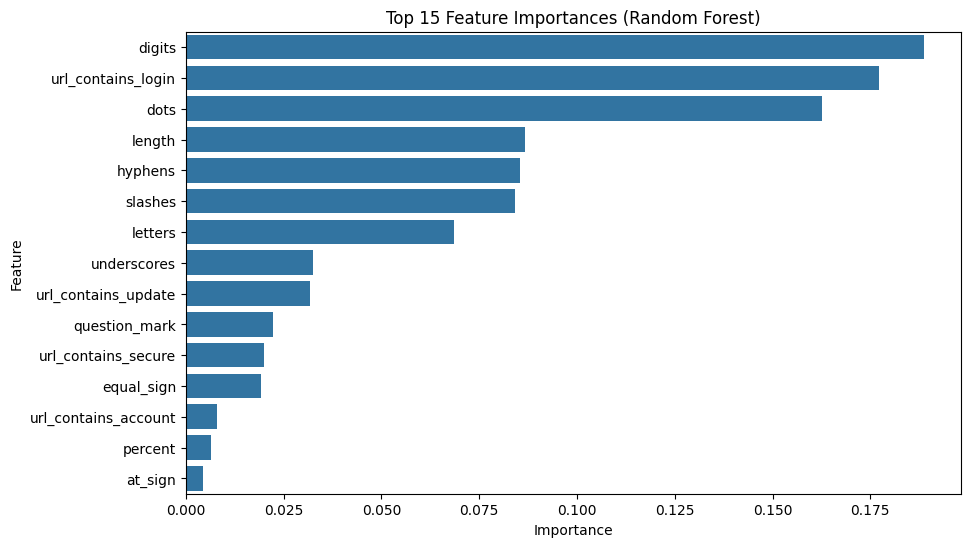

In [16]:
importances = rf.feature_importances_
feat_df = pd.DataFrame({'Feature': X_features.columns, 'Importance': importances})
feat_df = feat_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_df.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()

#**6. Testing**

In [17]:
def predict_url(url, model=rf):
    feats = extract_features(url).values.reshape(1, -1)
    pred = model.predict(feats)[0]
    prob = model.predict_proba(feats)[0]
    label = '.BAD (Phishing)' if pred == 1 else 'Good (Legitimate)'
    confidence = max(prob)
    return f"{label} | Confidence: {confidence:.2%}"

# Test examples
test_urls = [
    "https://www.google.com",
    "http://bit.ly/2Xb4QwA",
    "https://secure-login-bank-update.com/login.php",
    "http://192.168.1.1/admin",
    "https://paypal.secure-verify-account.ml/signin"
]

for url in test_urls:
    print(f"URL: {url}")
    print("→", predict_url(url))
    print("-" * 50)

URL: https://www.google.com
→ Good (Legitimate) | Confidence: 68.25%
--------------------------------------------------
URL: http://bit.ly/2Xb4QwA
→ Good (Legitimate) | Confidence: 58.78%
--------------------------------------------------
URL: https://secure-login-bank-update.com/login.php


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

→ .BAD (Phishing) | Confidence: 96.85%
--------------------------------------------------
URL: http://192.168.1.1/admin
→ .BAD (Phishing) | Confidence: 54.52%
--------------------------------------------------
URL: https://paypal.secure-verify-account.ml/signin
→ .BAD (Phishing) | Confidence: 78.18%
--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
